# 1. Thư viện và dữ liệu

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install transformers 

     |████████████████████████████████| 2.5MB 8.4MB/s 
     |████████████████████████████████| 901kB 36.2MB/s 
     |████████████████████████████████| 3.3MB 48.7MB/s 


In [ ]:
import torch
import pandas as pd
import numpy as np

# Thu vien transformer cho Classification
from transformers import AutoTokenizer, AutoModelForSequenceClassification, RobertaForSequenceClassification, Trainer, TrainingArguments, BertTokenizer, BertForSequenceClassification, XLMRobertaForSequenceClassification, RobertaForSequenceClassification

# Xu ly label
from sklearn.preprocessing import LabelEncoder

# Metric danh gia 
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score

# Ve do thi
import seaborn as sn
import matplotlib.pyplot as plt

In [ ]:
# Xay dung data de fit vao mo hinh 
class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
path = "/content/drive/MyDrive/Scocial Media Data Mining/Dataset"

In [ ]:
train = pd.read_csv(path + "/UIT-VSFC/VSFC_train.csv", index_col=False)
dev = pd.read_csv(path + "/UIT-VSFC/VSFC_dev.csv", index_col=False)
test = pd.read_csv(path + "/UIT-VSFC/VSFC_test.csv", index_col=False)


#Topics

In [ ]:
%cd "/content/drive/MyDrive/Scocial Media Data Mining/SourceCode/Thanh_Bert4News/UIT-VSFC/Topic"

/content/drive/.shortcut-targets-by-id/1CZcWZiWtxpQUuZayUBOYLquIpN5fLP1b/Scocial Media Data Mining/SourceCode/Thanh_Bert4News/UIT-VSFC/Topic


In [ ]:
X_train = train['Sents']
y_train = train['Topic'].values

X_dev = dev['Sents']
y_dev = dev['Topic'].values

X_test = test['Sents']
y_test = test['Topic'].values

In [ ]:
# encoding label 
le = LabelEncoder()
le.fit(y_train)

LabelEncoder()

In [ ]:
num_labels = len(np.unique(y_test))

In [ ]:
path_model = ""

In [ ]:
# Khai bao pre-trained
bert_model = BertForSequenceClassification.from_pretrained("NlpHUST/vibert4news-base-cased", num_labels = num_labels)
bert_tokenizer = BertTokenizer.from_pretrained("NlpHUST/vibert4news-base-cased")

Some weights of the model checkpoint at NlpHUST/vibert4news-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model 

In [ ]:
train_encodings = bert_tokenizer(X_train.to_list(), truncation=True, padding=True, max_length=40)
dev_encodings = bert_tokenizer(X_dev.to_list(), truncation=True, padding=True, max_length=40)
test_encodings = bert_tokenizer(X_test.to_list(), truncation=True, padding=True, max_length=40)

y_train_encoding = le.transform(y_train)
y_dev_encoding = le.transform(y_dev)
y_test_encoding = le.transform(y_test)

In [ ]:
# Chuan bi data

train_dataset = BuildDataset(train_encodings, y_train_encoding)
dev_dataset = BuildDataset(dev_encodings, y_dev_encoding)
test_dataset = BuildDataset(test_encodings, y_test_encoding)

**Chỉnh ./results khi train lại**

In [ ]:
# Chuan bi mo hinh

training_args = TrainingArguments(
    output_dir='./results_1',          
    num_train_epochs=100,              
    per_device_train_batch_size=32,  
    per_device_eval_batch_size=32,   
    warmup_steps=500,                
    weight_decay=0.01,
    no_cuda=False
)

bert_trainer = Trainer(
    model=bert_model,                         
    args=training_args,                  
    train_dataset=train_dataset,         
    eval_dataset=dev_dataset             
)

In [ ]:
# huan luyen mo hinh

bert_trainer.train()

Step,Training Loss
500,0.423100
1000,0.253500
1500,0.150700
2000,0.096800
2500,0.072200
3000,0.056400
3500,0.039400
4000,0.039700
4500,0.034300
5000,0.030500


TrainOutput(global_step=35800, training_loss=0.023359800809396005, metrics={'train_runtime': 9945.3075, 'train_samples_per_second': 114.888, 'train_steps_per_second': 3.6, 'total_flos': 3.665289501408e+16, 'train_loss': 0.023359800809396005, 'epoch': 100.0})

In [ ]:
# Du doan 
y_pred_classify = bert_trainer.predict(test_dataset)

y_pred = np.argmax(y_pred_classify.predictions, axis=-1)

In [ ]:
# Danh gia mo hinh
y_true = y_test_encoding

cf = confusion_matrix(y_true, y_pred)
print(cf)

evaluation = f1_score(y_true, y_pred, average='micro')

print("F1 - micro: " + str(evaluation))

evaluation = f1_score(y_true, y_pred, average='macro')
print("F1 - macro: " + str(evaluation))

[[2129  122    6   33]
 [  95  452    5   20]
 [   4    6  133    2]
 [  42   38    2   77]]
F1 - micro: 0.8815540113708149
F1 - macro: 0.7841836911107362


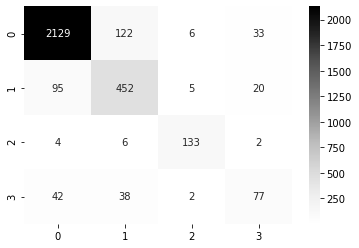

In [ ]:
# Ve ma tran nham lan
df_cm = pd.DataFrame(cf, index = np.unique(y_train),
                  columns = np.unique(y_train))

sn.heatmap(df_cm, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 10})

**Note**

'0' is a label related to the lecturer topic.

'1' is a label related to the training program topic.

'2' is a label related to the facility topic.

'3' is a label related to others.

#Code đánh giá mô hình chi tiết trên 4 độ đo

In [ ]:
print(pd.Series(y_test).unique())
print(pd.Series(y_true).unique())

[0 1 3 2]
[0 1 3 2]


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
# Danh gia mo hinh
y_true = y_test_encoding
y_pred_classify = bert_trainer.predict(test_dataset)
y_pred = np.argmax(y_pred_classify.predictions, axis=-1)
cf = confusion_matrix(y_true, y_pred, labels= pd.Series(y_true).unique())

print(cf)
print("accuracy: " + str(accuracy_score(y_true, y_pred)))
print("F1 - macro: " + str(f1_score(y_true, y_pred, average='macro')))
target_names = pd.Series(y_test).astype(str).unique()
print('Classification report in Training set')
print(classification_report(y_true, y_pred, labels=pd.Series(y_true).unique(), target_names=target_names))

[[2129  122   33    6]
 [  95  452   20    5]
 [  42   38   77    2]
 [   4    6    2  133]]
accuracy: 0.8815540113708149
F1 - macro: 0.7841836911107362
Classification report in Training set
              precision    recall  f1-score   support

           0       0.94      0.93      0.93      2290
           1       0.73      0.79      0.76       572
           3       0.58      0.48      0.53       159
           2       0.91      0.92      0.91       145

    accuracy                           0.88      3166
   macro avg       0.79      0.78      0.78      3166
weighted avg       0.88      0.88      0.88      3166



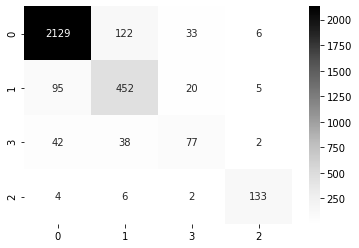

In [ ]:
# Ve ma tran nham lan
df_cm = pd.DataFrame(cf, index = pd.Series(y_true).unique(),
                  columns = pd.Series(y_test).unique())

sn.heatmap(df_cm, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 10})